# 1. Parallelism in Tensorflow

## Distributed training
When faced with a huge task, we often divide it into smaller subtasks and run them in parallel to save time and make the process feasible. This is also true for deep learning, which is why we use distributed training. 

In distributed training, we split the training workload of a large deep learning model across multiple processors, also known as worker nodes or simply workers. These workers are trained in parallel to speed up the training process. There are two primary approaches to parallelism: data parallelism and model parallelism.

## Data parallelism

This approach can be explain in 3 steps: 


1. We split the data into $n$ number of partitions, where $n$ is the total number of available workers in the compute cluster.

2. We copy the model in each worker node and each one of them performs the training on its own subset of the data.

3. We synchronize the model parameters, or gradients, at the end of the batch computation.


### Synchronous training 

Data parallelism involves dividing the data into partitions and distributing each part to a worker. Each worker trains on a portion of the data using a full replica of the model.


1.  During synchronous training, all workers perform the forward pass simultaneously, producing different outputs and gradients. The workers then wait for the other workers to complete their training loops and calculate gradients.

2.  Next, the workers communicate with each other and use the all-reduce algorithm to aggregate the gradients. Now after all the workers have completed computing gradients, all of them start communicating with each other and aggregate the gradients using the all-reduce algorithm, which we will discuss ahead. 

3.  Once the gradients are combined, the updated gradients are sent to all workers. Each worker can then perform the backward pass and update the local copy of the weights.

4.  The next forward pass does not begin until all workers have updated their weights, making this approach synchronous.

It is important to note that each worker produces different gradients because they train on different subsets of the data. However, at any given time, all workers have the same weights.




### All-reduce algorithm


The all-reduce algorithm is used to enable workers to share the load of storing and maintaining global parameters. With this algorithm, each worker shares its gradients with all other workers and applies a reduction operation to the target arrays. This reduces the target arrays in all workers to a single array, which is then returned to all workers.

There are several different implementations of the all-reduce algorithm, which dictate how these parameters are calculated and shared. 


1.  One such implementation involves all workers sending their gradients to a single "driver" worker, responsible for reducing the gradients and sending the updated gradients back to all workers. However, this approach can become a bottleneck as the number of processes increases, limiting its scalability.

2.  A less naive approach is the ring-all reduce algorithm, in which workers are organized in a ring, with each worker responsible for a specific subset of parameters shared only with the next worker in the ring. This approach dramatically reduces synchronization overhead and is a valuable tool for scaling machine learning models.

### Parameter server
Distributed training involves a cluster of workers, typically performing a singular task of training. However, it's possible to designate unique roles to each worker. For instance, some can act as parameter servers while others train the model.

The parameter servers hold and update the global state of the model's parameters, while the training workers execute the training loop, producing gradients and loss from the assigned data.

The training process can be summarized as follows: 
*  the model is replicated in all workers, and each worker uses a subset of data to train. 
*  Each training worker fetches the parameters from the parameter servers, 
*  Each training worker performs a training loop, and returns the gradients to all the parameter servers for updating the model's parameters.

Although this method allows independent training, it has a drawback. 
1.  At any given time, only one worker uses the latest version of the model, while the others rely on the outdated version. 
2.  Additionally, using a single worker as a parameter server can cause bottlenecks or a single point of failure in large clusters. However, this bottleneck issue can be mitigated to some degree by introducing multiple parallel servers.

## Get started 
 
TensorFlow has a specific API to use Multiple GPUs for training and inference: `tf.distribute.Strategy` 
It allows you to do distributed training using existing models and training code with minimal changes.

We will use the `tf.distribute.MirroredStrategy` to perform in-graph replication with _synchronous training on 2 GPUs on this notebook. The strategy essentially copies all of the model's variables to each processor. Then, it uses `all reduce` to combine the gradients from all processors, and applies the combined value to all copies of the model.

We will use the `tf.keras` APIs to build the model and `Model.fit` for training it.


### GPUs Specifications

In [1]:
!nvidia-smi

Fri Nov 17 17:55:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

Now that you know you have the proper hardware for testing, lets see how to train a model in Keras with both GPUs

## MNIST

We will use the **MNIST** dataset for our experimentation.

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import time


(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

img_rows, img_cols = 28, 28
input_shape = (img_rows, img_cols, 1)

X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)

## conveting the images to float32
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

## converting the range to [0,1]
X_train /= 255
X_test /= 255

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


11490434/11490434 [==============================] - 0s 0us/step


In [3]:
len(X_train)

60000

Let's take a quick look at the data we've just loaded

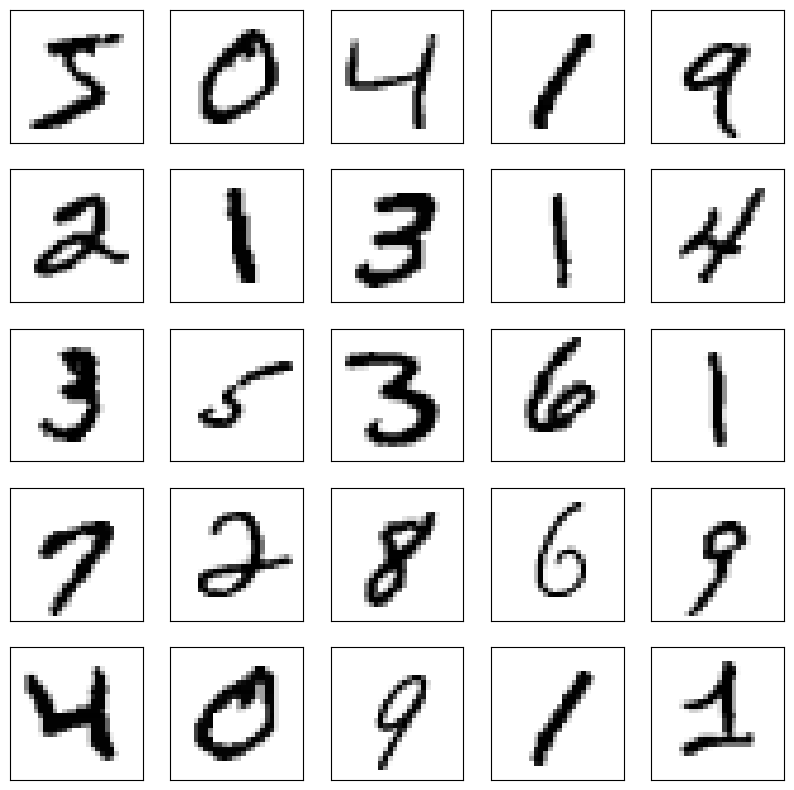

In [4]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
plt.show()

#### One important detail here is the BATCH_SIZE. To get the benefits of multiple GPUs, we have to optimize their use, otherwise we won't see the gains.

In [5]:
BUFFER_SIZE = len(X_train)
BATCH_SIZE_PER_REPLICA = 1024

def get_batch_size(num_gpus=1):
    batch_size = BATCH_SIZE_PER_REPLICA * num_gpus
    print(f'BATCH_SIZE = {batch_size}')
    return batch_size

# Wrap data in Dataset objects.
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# the batch size will be defined later based on the number of used GPUs
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.OFF
train_data = train_data.with_options(options).cache().shuffle(BUFFER_SIZE).prefetch(tf.data.AUTOTUNE)
test_data = test_data.with_options(options)

## Defining a Distribution Strategy

To use Multi GPU (or multi machine, multi TPU) we will use the `tf.distribute.Strategy` API, 
more specifically `tf.distribute.MirroredStrategy`

This strategy will do the spliting of the work between both T4s

In [6]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 2


## Building the model
The model has to be created inside a Strategy scope. The scope will make sure to place the model's variables on each processor. Then, it uses all-reduce to combine the gradients from all processors, and applies the combined value to all copies of the model.
To make sure we see the benefit of training in multiple GPUs, we always need to:
- use large enough batch size
otherwise, the cost of communicating between GPUs will eat up the gains of training the model.

In [7]:
import tensorflow as tf

def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),
        tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
        tf.keras.layers.Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),
        tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])
    
    return model


In [8]:
# buiding a model inside the strategy scope
with strategy.scope():
    multi_gpu_model = build_model()
    
multi_gpu_model.summary()

# buiding a regular model on 1 GPU for performance comparison
regular_model = build_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 28, 28, 32)        128       
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 28, 28, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 28, 28, 64)        256       
 chNormalization)                                                
                                                                 
 re_lu_1 (ReLU)              (None, 28, 28, 64)        0

## Warmup

We still didn't use the GPUs yet!! The first time we access them, the framework will load aditional libraries not yet in memory and this would impact the timing of training the model.

On a regular situation, that doesn't affect much, it would just make the first epoch of training be slower but since we'll compare timing results later, it's better to warmup the GPUs by just running a predict on some data. The result doesn't matter but it will load all necessary libraries to memory.

In [9]:
import warnings
warnings.filterwarnings("ignore")
EPOCHS = 5

d_train_data = train_data.batch(get_batch_size(strategy.num_replicas_in_sync))
history = multi_gpu_model.fit(d_train_data, epochs=EPOCHS)

BATCH_SIZE = 2048
Epoch 1/5
30/30 [==============================] - 3s 105ms/step - loss: 0.2768 - accuracy: 0.9276
Epoch 3/5
30/30 [==============================] - 3s 106ms/step - loss: 0.1767 - accuracy: 0.9557
Epoch 4/5
30/30 [==============================] - 3s 104ms/step - loss: 0.1292 - accuracy: 0.9680
Epoch 5/5
30/30 [==============================] - 3s 103ms/step - loss: 0.1047 - accuracy: 0.9737


## Training on 2 GPUs

In [10]:
EPOCHS = 30

d_train_data = train_data.batch(get_batch_size(strategy.num_replicas_in_sync))

start_time_multi = time.time()
history_multi = multi_gpu_model.fit(d_train_data, epochs=EPOCHS)
final_time_multi = time.time() - start_time_multi
print("--- %s seconds ---" % (final_time_multi))

BATCH_SIZE = 2048
Epoch 1/30
30/30 [==============================] - 3s 105ms/step - loss: 0.0863 - accuracy: 0.9787
Epoch 2/30
30/30 [==============================] - 3s 104ms/step - loss: 0.0725 - accuracy: 0.9821
Epoch 3/30
30/30 [==============================] - 3s 103ms/step - loss: 0.0652 - accuracy: 0.9833
Epoch 4/30
30/30 [==============================] - 3s 102ms/step - loss: 0.0577 - accuracy: 0.9850
Epoch 5/30
30/30 [==============================] - 3s 104ms/step - loss: 0.0501 - accuracy: 0.9868
Epoch 6/30
30/30 [==============================] - 3s 103ms/step - loss: 0.0461 - accuracy: 0.9882
Epoch 7/30
30/30 [==============================] - 3s 104ms/step - loss: 0.0430 - accuracy: 0.9888
Epoch 8/30
30/30 [==============================] - 3s 103ms/step - loss: 0.0384 - accuracy: 0.9899
Epoch 9/30
30/30 [==============================] - 3s 107ms/step - loss: 0.0355 - accuracy: 0.9904
Epoch 10/30
30/30 [==============================] - 3s 105ms/step - loss: 0.0350 

In [ ]:
test_loss, test_accuracy = multi_gpu_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

313/313 [==============================] - 2s 5ms/step - loss: 0.0182 - accuracy: 0.9953
Test Accuracy: 99.53%


Just for a simple comparison, you'll create a model without the the distribution strategy

The dataset will also have a proportional batch size since it's doing all the work alone

aside from the first epoch which may be faster, all the other ones will be slower than with multiple GPUs

## Training on 1 GPU

In [ ]:
regular_train_data = train_data.batch(2048)


start_time_single = time.time()
history_regular = regular_model.fit(regular_train_data, epochs=EPOCHS)
final_time_single = time.time() - start_time_single
print("--- %s seconds ---" % (final_time_single))

Epoch 1/30
30/30 [==============================] - 11s 160ms/step - loss: 0.8958 - accuracy: 0.7332
Epoch 2/30
30/30 [==============================] - 5s 160ms/step - loss: 0.2651 - accuracy: 0.9314
Epoch 3/30
30/30 [==============================] - 5s 160ms/step - loss: 0.1675 - accuracy: 0.9582
Epoch 4/30
30/30 [==============================] - 5s 160ms/step - loss: 0.1244 - accuracy: 0.9700
Epoch 5/30
30/30 [==============================] - 5s 160ms/step - loss: 0.0972 - accuracy: 0.9762
Epoch 6/30
30/30 [==============================] - 5s 161ms/step - loss: 0.0827 - accuracy: 0.9797
Epoch 7/30
30/30 [==============================] - 5s 160ms/step - loss: 0.0739 - accuracy: 0.9821
Epoch 8/30
30/30 [==============================] - 5s 161ms/step - loss: 0.0639 - accuracy: 0.9840
Epoch 9/30
30/30 [==============================] - 5s 161ms/step - loss: 0.0583 - accuracy: 0.9854
Epoch 10/30
30/30 [==============================] - 5s 161ms/step - loss: 0.0503 - accuracy: 0.987

In [ ]:
test_loss, test_accuracy = regular_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

313/313 [==============================] - 1s 3ms/step - loss: 0.0231 - accuracy: 0.9942
Test Accuracy: 99.42%


## Performance Comparison

### Accuracy Comparison

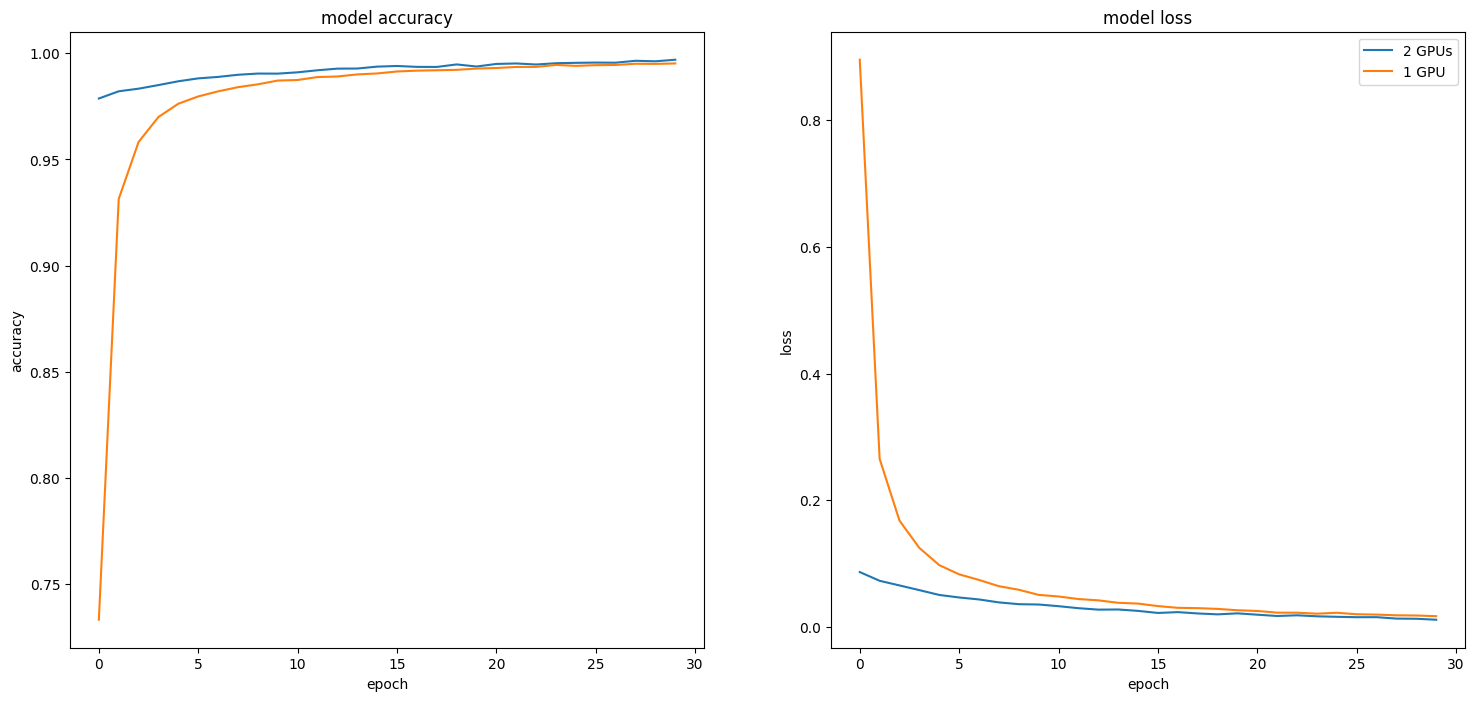

In [ ]:
fig, axs = plt.subplots(1, 2,figsize=(18,8))
axs[0].plot(history_multi.history['accuracy'],label = '2 GPUs')
axs[0].plot(history_regular.history['accuracy'],label = '1 GPU')
axs[0].set_title('model accuracy')
axs[0].set_ylabel('accuracy')
axs[0].set_xlabel('epoch')


axs[1].plot(history_multi.history['loss'],label = '2 GPUs')
axs[1].plot(history_regular.history['loss'],label = '1 GPU')
axs[1].set_title('model loss')
axs[1].set_ylabel('loss')
axs[1].set_xlabel('epoch')

plt.legend()
plt.show()

### Computing Power Comparison

We achieve 73.62 percent of scaling


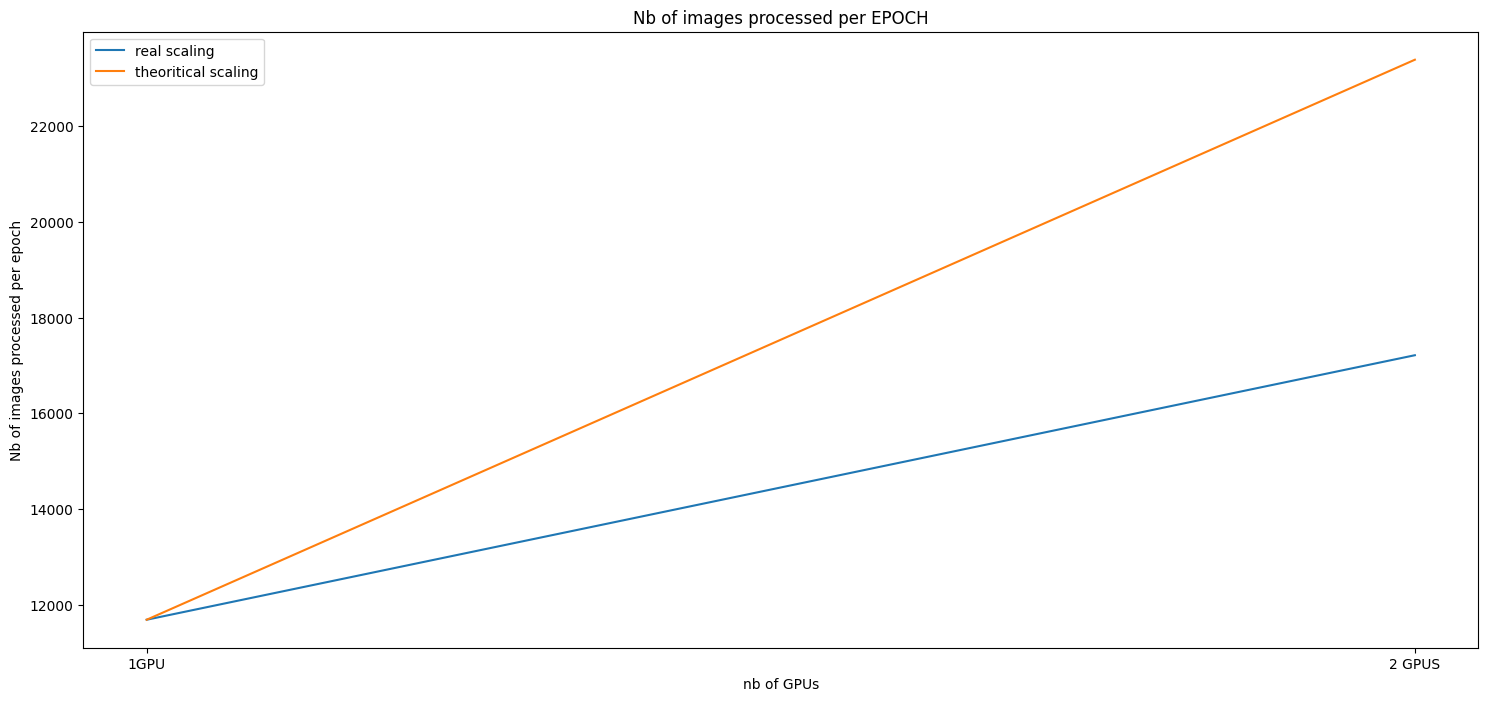

In [ ]:
plt.figure(figsize=(18,8))
nb_images = len(train_data)
plt.plot(['1GPU','2 GPUS'],[nb_images/(final_time_single/EPOCHS),nb_images/(final_time_multi/EPOCHS)],label = 'real scaling')
plt.plot(['1GPU','2 GPUS'],[nb_images/(final_time_single/EPOCHS),2*nb_images/(final_time_single/EPOCHS)],label = 'theoritical scaling')
plt.title('Nb of images processed per EPOCH')
plt.ylabel('Nb of images processed per epoch')
plt.xlabel('nb of GPUs')
plt.legend()
print("We achieve %s percent of scaling"% round((final_time_single/(2*final_time_multi))*100,2))

When going from training with a single GPU to multiple GPUs on the same host, ideally you should experience the performance scaling with only the additional overhead of gradient communication and increased host thread utilization. Because of this overhead, you will not have an exact 2x speedup if you move from 1 to 2 GPUs, for example.

## Evaluation of models

## 1. Parallel Model

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import seaborn as sns

In [ ]:
y_true = y_test
y_pred = multi_gpu_model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
confusion = confusion_matrix(y_true, y_pred_labels)
classification_report_str = classification_report(y_true, y_pred_labels)


print("Classification Report:\n", classification_report_str)

313/313 [==============================] - 2s 4ms/step
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       0.99      1.00      1.00      1135
           2       1.00      0.99      1.00      1032
           3       0.99      1.00      1.00      1010
           4       0.99      1.00      0.99       982
           5       1.00      0.99      0.99       892
           6       1.00      0.99      1.00       958
           7       0.99      0.99      0.99      1028
           8       1.00      1.00      1.00       974
           9       0.99      0.99      0.99      1009

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



<Axes: >

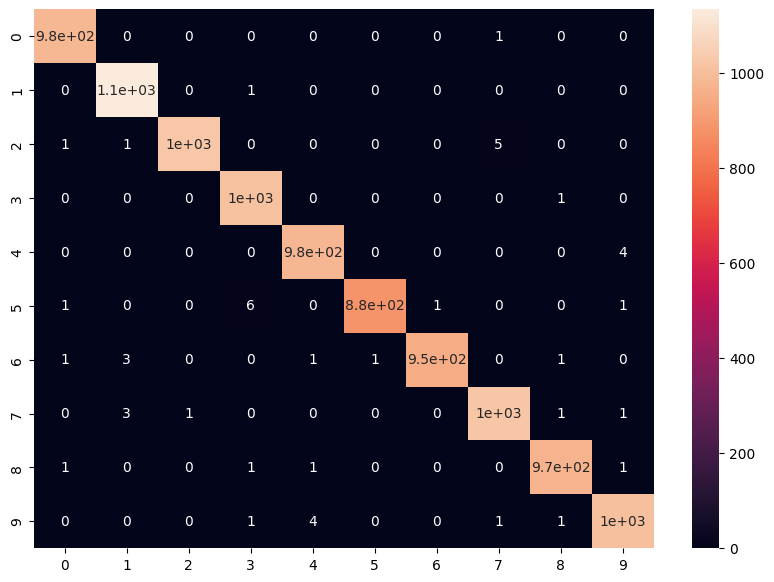

In [ ]:
#print("Confusion Matrix:\n", confusion)

df_cm = pd.DataFrame(confusion, index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)

## 2. Regular model

In [ ]:
y_true = y_test
y_pred = regular_model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
confusion = confusion_matrix(y_true, y_pred_labels)
classification_report_str = classification_report(y_true, y_pred_labels)


print("Classification Report:\n", classification_report_str)

313/313 [==============================] - 1s 2ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       980
           1       0.99      1.00      1.00      1135
           2       1.00      0.99      0.99      1032
           3       1.00      1.00      1.00      1010
           4       0.99      1.00      1.00       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      1.00       958
           7       0.99      0.99      0.99      1028
           8       1.00      0.99      0.99       974
           9       1.00      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



<Axes: >

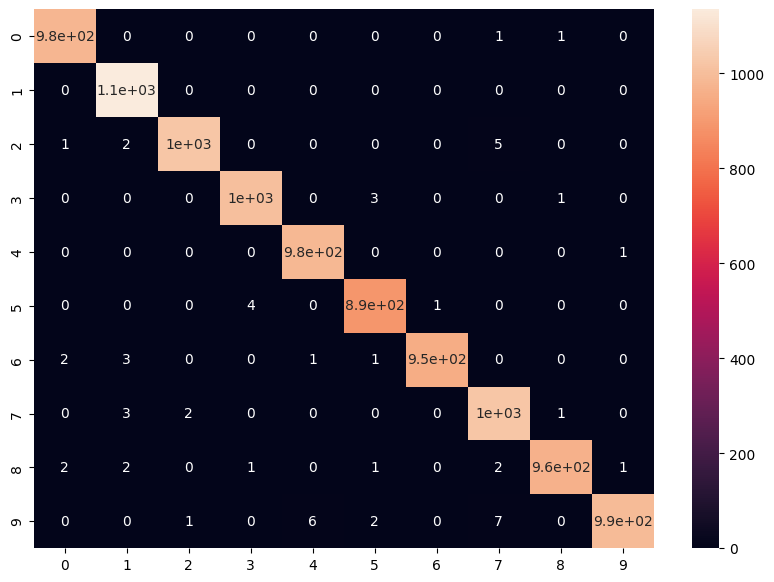

In [ ]:
df_cm = pd.DataFrame(confusion, index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)